# Reflect Tables into SQLAlchemy ORM

In [1]:
# from matplotlib import style
# style.use('fivethirtyeight')

# data science
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

In [2]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# Inspect
inspector_gadget = inspect(engine)

tables = inspector_gadget.get_table_names()

for table in tables:
    print(table)
    print("..........")
    
    columns = inspector_gadget.get_columns(table)
    for column in columns:
            print(column["name"], column["type"])

    print()


measurement
..........
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
..........
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [4]:
# Declare a Base using `automap_base()`
base = automap_base()
# Use the Base class to reflect the database tables
base.prepare(autoload_with=engine)

In [5]:
# Print all of the classes mapped to the Base
print(list(base.classes))

[<class 'sqlalchemy.ext.automap.station'>, <class 'sqlalchemy.ext.automap.measurement'>]


In [6]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
measurement = base.classes.measurement
station = base.classes.station

In [7]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [8]:
# Find the most recent date in the data set.
mrd = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(mrd)

('2017-08-23',)


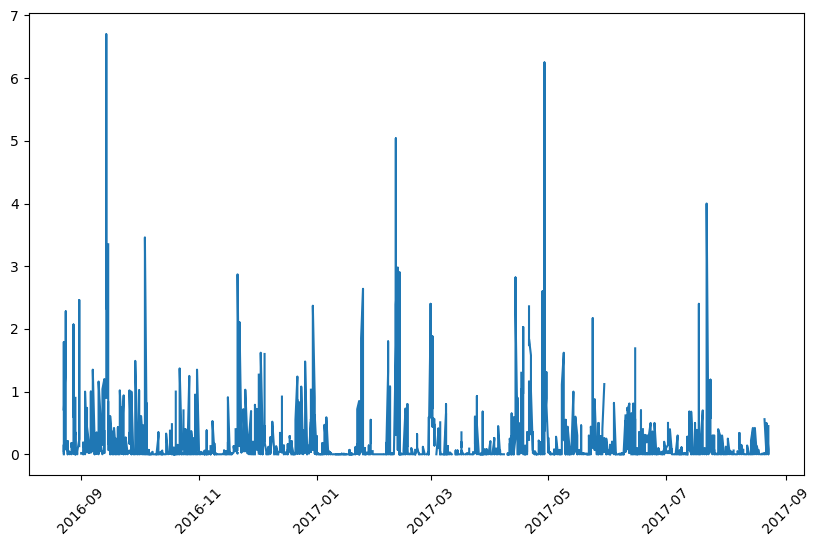

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.

s_date = datetime.date(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores

prcptn = session.query(measurement.date, measurement.station, measurement.prcp).filter(measurement.date >= s_date).order_by(measurement.date.asc()).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(prcptn, columns=["date", "station", "precipitation"])

# Sort the dataframe by date
df["date"] = pd.to_datetime(df["date"])
df2 = df.sort_values(by="date", ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize = (10,6))
plt.plot(df2.date, df2.precipitation)
plt.xticks(rotation=45)
plt.show()
plt.show()

In [10]:
# Use Pandas to calculate the summary statistics for the precipitation data
df2.precipitation.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [11]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.id)).all()

[(9,)]

In [12]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active = session.query(measurement.station, func.count(measurement.date)).group_by(measurement.station).order_by(func.count(measurement.date).desc()).all()

df3 = pd.DataFrame(active, columns = ["Station", "Observed"])
df3.head()

,Station,Observed
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [13]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
                    filter(measurement.station == 'USC00519281').all()

# Create a DataFrame to display the temperature statistics
df_temperature_stats = pd.DataFrame(temperature_stats, columns=["min temperature", "max temperature", "avg temperature"])

df_temperature_stats.head()

,min temperature,max temperature,avg temperature
0,54.0,85.0,71.663781


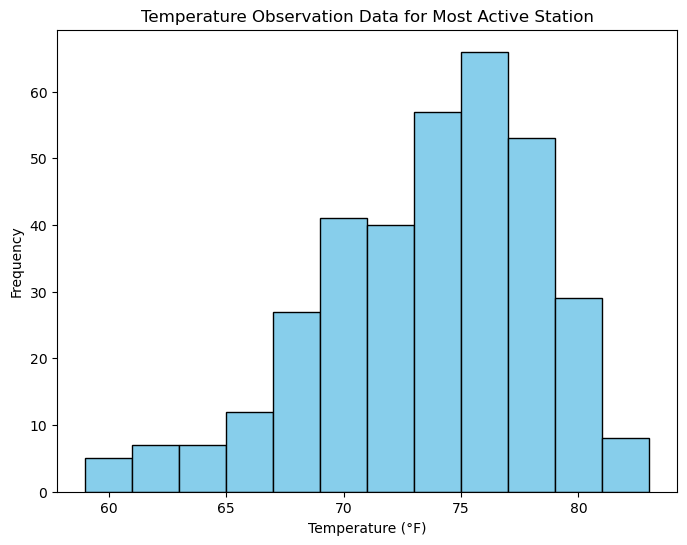

In [14]:
# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(measurement.tobs).\
                    filter(measurement.station == 'USC00519281').\
                    filter(measurement.date >= '2016-08-23').all()

# Extract the temperature data into a list
temperature_list = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_list, bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for Most Active Station')
plt.show()

# Close Session

In [15]:
# Close Session
session.close()